In [1]:
import pandas as pd
import csv, gzip, json
import seaborn as sb
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import glob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import digits
import re
from random import seed
import os, gzip, json
from itertools import islice, izip
import codecs
from collections import defaultdict, Counter
from itertools import combinations
from scipy.sparse import csr_matrix
import scipy as sp
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
h_user_mean_cooc = dict()
l_user_mean_cooc = dict()

source_csv = '/home/shruvp5/ICWSM/tenplus/'
years = [2016, 2017]
for year in years:
    for i in range(1, 13):
        if i == 1:
            csv1 = source_csv + str(year) + '_' + str('{:02d}'.format(i)) + '_final.csv'
            csv2 = source_csv + str(year-1) + '_' + str('{:02d}'.format(12)) + '_final.csv'
            csv3 = source_csv + str(year-1) + '_' + str('{:02d}'.format(11)) + '_final.csv'

        elif i == 2:

            csv1 = source_csv + str(year) + '_' + str('{:02d}'.format(i)) + '_final.csv'
            csv2 = source_csv + str(year) + '_' + str('{:02d}'.format(i-1)) + '_final.csv'
            csv3 = source_csv + str(year-1) + '_' + str('{:02d}'.format(12)) + '_final.csv'

        else:
            csv1 = source_csv + str(year) + '_' + str('{:02d}'.format(i)) + '_final.csv'
            csv2 = source_csv + str(year) + '_' + str('{:02d}'.format(i-1)) + '_final.csv'
            csv3 = source_csv + str(year) + '_' + str('{:02d}'.format(i-2)) + '_final.csv'

 
        curr = pd.read_csv(csv1, header=None, names=['index', 'author', 'count'])
        p1 = pd.read_csv(csv2, header=None, names=['index', 'author', 'count'])
        p2 = pd.read_csv(csv3, header=None, names=['index', 'author', 'count'])
        
        curr_high = curr.loc[curr['count'] >= np.percentile(np.array(curr['count']), 75), 'author'].tolist()
        curr_low = curr.loc[curr['count'] <= np.percentile(np.array(curr['count']), 25), 'author'].tolist()
        
        
        #commented for calculating p-value
        #h_recp = []
        #l_recp = []
        
        
        try:
            p1_high = p1.loc[p1['count'] >= np.percentile(np.array(p1['count']), 75), 'author'].tolist()
        except:
            p1_high = []

        
        try:
            p2_high = p2.loc[p2['count'] >= np.percentile(np.array(p2['count']), 75), 'author'].tolist()
        except:
            p2_high = []
            
            
        past_high = list(set(p1_high).union(set(p2_high)))
        
        fname = '/home/shruvp5/ICWSM/ties/' + str(year) + '_' + str('{:02d}'.format(i)) + '.csv'
        frame1 = pd.read_csv(fname, header=None, names=['author', 'subreddit', 'name', 'parent_id'])
        frame = frame1.loc[frame1['author']!='AutoModerator']
        
        
        # At this point we have a list of current high users as curr_high and current low users as curr_low and
        # past high users as past_high
        # Alongwith this we have a dataframe called frame which has comment history of all of these users in
        # the two months prior to the month of considersation
        
        
        user_cooc = frame[['author', 'subreddit']].copy()
        user_cooc = user_cooc.drop_duplicates()
        temp_file = './tempembed/' + str(year) + str(i) + '_userembedtemp.gz'
        user_cooc.to_csv(temp_file, sep=',', compression='gzip')
        dense_source = temp_file
        
           
        
        user_map = dict()
        sub_map = dict()
        user_idx = 0
        sub_idx = 0
        reverse_sub_map = dict()
        p_sparse = defaultdict(lambda: Counter())
        test_counter = 0
        
        # attention: reverse_sub map here is actually mapping user index to user name [not related to subs]
        with gzip.open(dense_source, 'r') as gfile:
            for line in gfile:
                test_counter+=1
                if test_counter==1:
                    pass
                pair = line.strip().split(',')
                if pair[1] not in user_map:
                    user_map[pair[1]] = user_idx
                    reverse_sub_map[user_idx] = pair[1]
                    user_idx +=1
                if pair[2] not in sub_map:
                    sub_map[pair[2]] = sub_idx
                    sub_idx +=1
                p_sparse[sub_map[pair[2]]][user_map[pair[1]]] +=1
        

        cooccurrences = Counter()
        cooccurrences_arr, user_arr, sub_arr = zip(*[(count, user, sub) for sub, d in p_sparse.iteritems() for user, count in d.iteritems()])
        cooccurrences = csr_matrix((np.ones_like(cooccurrences_arr), (user_arr, sub_arr)))
        del cooccurrences_arr, sub_arr, user_arr
        cooccurrences_square = cooccurrences.dot(cooccurrences.T)
        cooccurrences_square
        
        cooccurrences_square = cooccurrences_square.todense()
        pxy = cooccurrences_square/float(cooccurrences_square.sum())
        px = py = pxy.sum(axis=0)
        pmi = np.log2(np.divide(pxy, np.outer(px.T, py)))
        ppmi = pmi.copy()
        print np.max(np.max(pmi))
        print np.min(np.min(pmi))
        ppmi[ppmi < 0.] = 0.
        #ppmi[math.isnan(ppmi)] = 0.
        ppmi = np.nan_to_num(ppmi)

        high_cooc = []
        low_cooc = []

        for i in range(ppmi.shape[0]):
            if reverse_sub_map[i] in curr_high:
                temparray =[]
                for j in range(i, ppmi.shape[1]):
                    if reverse_sub_map[j] in past_high:
                        if ppmi[i, j] != float('NaN'):
                            temparray.append(ppmi[i, j])
                if np.mean(np.array(temparray)) >=0.:
                    if reverse_sub_map[i] not in h_user_mean_cooc:
                        h_user_mean_cooc[reverse_sub_map[i]] = np.mean(np.array(temparray))
                    high_cooc.append(np.mean(np.array(temparray)))

            elif reverse_sub_map[i] in curr_low:
                temparray =[]
                for j in range(i, ppmi.shape[1]):
                    if reverse_sub_map[j] in past_high:
                        if ppmi[i, j] != float('NaN'):
                            temparray.append(ppmi[i, j])

                if np.mean(np.array(temparray)) >=0.:
                    if reverse_sub_map[i] not in l_user_mean_cooc:
                        l_user_mean_cooc[reverse_sub_map[i]] = np.mean(np.array(temparray))
                    low_cooc.append(np.mean(np.array(temparray)))

        
        


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log2


21.9116033778
-inf
22.8811057434
-inf


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


23.4327992889
-inf
23.0941223168
-inf
23.0546261763
-inf
23.1333513967
-inf
23.5380482265
-inf
24.0253434605
-inf
24.4077146493
-inf
24.8982822965
-inf
25.6279662471
-inf
26.3041346842
-inf
26.6597601298
-inf
26.7944832572
-inf
26.7925456029
-inf
26.5737203916
-inf
26.5517978099
-inf
26.540884115
-inf
26.4775342519
-inf
24.6629831885
-inf
26.1497776788
-inf
26.6945908398
-inf
27.0613550093
-inf
27.2127475041
-inf


sb.set(style="whitegrid")
sb.set(rc={'figure.figsize':(5,5)})
sb.distplot(high_cooc, kde=False, rug=True)


sb.set(style="whitegrid")
sb.set(rc={'figure.figsize':(5,5)})
sb.distplot(low_cooc, kde=False, rug=True)


print np.mean(high_cooc)
print np.mean(low_cooc)

In [4]:
print len(h_user_mean_cooc.values())

5606


In [5]:
print len(l_user_mean_cooc.values())

12337


In [6]:
all_scores = np.array(h_user_mean_cooc.values() + l_user_mean_cooc.values())

In [7]:
print all_scores.min()
print all_scores.max()
print all_scores.mean()
print all_scores.std()

0.0
5.52651460186
0.312782637706
0.313396507754


In [8]:
import scipy
from scipy import stats

m, v, s, k = stats.t.stats(10, moments='mvsk')

In [9]:
n, (smin, smax), sm, sv, ss, sk = stats.describe(all_scores)

In [10]:
print('t-statistic = %6.3f pvalue = %6.4f' %  stats.ttest_1samp(all_scores, m))

t-statistic = 133.685 pvalue = 0.0000


In [11]:
with open('high_subcooc.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in h_user_mean_cooc.items():
        writer.writerow([key, value])


In [12]:
with open('low_subcooc.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in l_user_mean_cooc.items():
        writer.writerow([key, value])


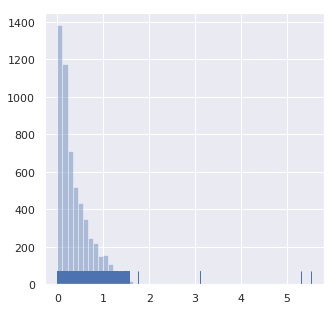

In [13]:
sb.set(style="whitegrid")
sb.set(rc={'figure.figsize':(5,5)})
sb.distplot(h_user_mean_cooc.values(), kde=False, rug=True)


In [18]:
print np.array(h_user_mean_cooc.values()).min()
print np.array(h_user_mean_cooc.values()).max()
print np.array(h_user_mean_cooc.values()).mean()
print np.array(h_user_mean_cooc.values()).std()

0.0
5.52651460186
0.377986849117
0.363104948416


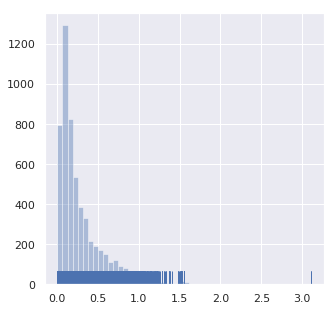

In [16]:
from random import sample
sb.set(style="whitegrid")
sb.set(rc={'figure.figsize':(5,5)})
sb.distplot(random.sample(l_user_mean_cooc.values(), len(h_user_mean_cooc)), kde=False, rug=True)


In [19]:
print np.array(l_user_mean_cooc.values()).min()
print np.array(l_user_mean_cooc.values()).max()
print np.array(l_user_mean_cooc.values()).mean()
print np.array(l_user_mean_cooc.values()).std()

0.0
3.11011712357
0.283153488872
0.283066898578
